In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best Parameters:
{'depth': 6, 'iterations': 429, 'learning_rate': np.float64(0.09003976278653757), 'subsample': np.float64(0.718509402281633)}

=== Test Set Evaluation ===
MAE   : 37.87
RMSE  : 64.96
sMAPE : 8.05%
R²    : 0.963


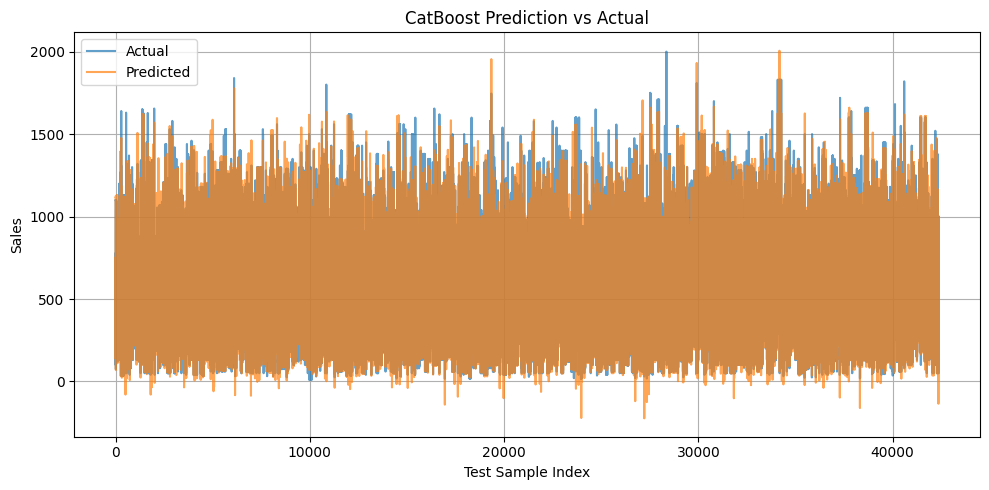

In [ ]:
# === Install CatBoost ===
!pip install -q catboost scikit-learn

# === Imports ===
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# === Load Dataset ===
file_path = "/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Final_Selected_Features_new.csv"
df = pd.read_csv(file_path, parse_dates=["date_only"])
df = df.sort_values("date_only")

# === Feature/Target Split ===
target = "Sales"
X = df.drop(columns=["Sales", "date_only"]).select_dtypes(include=[np.number])
y = df[target]

# === Normalize ===
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# === Train-Test Split (no shuffle) ===
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# === Define CatBoost Regressor & Param Space ===
cat_model = CatBoostRegressor(verbose=0, random_state=42)

param_dist = {
    "iterations": randint(50, 601),
    "depth": randint(3, 7),
    "learning_rate": uniform(0.01, 0.29),  # 0.01 to 0.3
    "subsample": uniform(0.6, 0.4),        # 0.6 to 1.0
}

# === Randomized Search ===
random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(X_train, y_train)

# === Best Model ===
best_model = random_search.best_estimator_
print("\nBest Parameters:")
print(random_search.best_params_)

# === Predict and Evaluate ===
y_pred = best_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred)
    return np.mean(np.where(denominator == 0, 0, diff / denominator)) * 100

s_mape = smape(y_test.values, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n=== Test Set Evaluation ===")
print(f"MAE   : {mae:.2f}")
print(f"RMSE  : {rmse:.2f}")
print(f"sMAPE : {s_mape:.2f}%")
print(f"R²    : {r2:.3f}")

# === Plot ===
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual", alpha=0.7)
plt.plot(y_pred, label="Predicted", alpha=0.7)
plt.title("CatBoost Prediction vs Actual")
plt.xlabel("Test Sample Index")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/MRP/Current/Deliverables/Methodology_&_Experiments/Report/Coding/Data_files/Plots/catboost_prediction_vs_actual.png")
plt.show()
